In [23]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.RandomState(42)
import pandas as pd

## Funções: split, padronização, métricas

In [3]:

def train_test_split(X, y, test_size=0.25, random_state=42, stratify=None):
    rng = np.random.RandomState(random_state)
    X = np.asarray(X); y = np.asarray(y)
    n = len(y)
    if stratify is None:
        idx = rng.permutation(n)
        n_test = int(np.floor(test_size * n))
        test_idx = idx[:n_test]; train_idx = idx[n_test:]
    else:
        labels = np.unique(stratify)
        train_idx, test_idx = [], []
        for c in labels:
            idx_c = np.where(stratify == c)[0]
            idx_c = rng.permutation(idx_c)
            n_test_c = int(np.floor(test_size * len(idx_c)))
            test_idx.extend(idx_c[:n_test_c]); train_idx.extend(idx_c[n_test_c:])
        train_idx = np.array(train_idx, dtype=int); test_idx = np.array(test_idx, dtype=int)
        rng.shuffle(train_idx); rng.shuffle(test_idx)
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

class StandardScaler:
    def __init__(self): self.mean_=None; self.std_=None
    def fit(self, X):
        X=np.asarray(X)
        self.mean_=X.mean(axis=0); self.std_=X.std(axis=0); self.std_[self.std_==0]=1.0
        return self
    def transform(self, X): return (np.asarray(X)-self.mean_)/self.std_
    def fit_transform(self, X): return self.fit(X).transform(X)

def confusion_matrix(y_true, y_pred, labels=None):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    if labels is None: labels = np.unique(np.concatenate([y_true,y_pred]))
    lab_to_idx = {lab:i for i,lab in enumerate(labels)}
    M = np.zeros((len(labels), len(labels)), dtype=int)
    for t,p in zip(y_true, y_pred):
        M[lab_to_idx[t], lab_to_idx[p]] += 1
    return M, labels

def accuracy(y_true, y_pred): return float(np.mean(np.asarray(y_true)==np.asarray(y_pred)))

def precision_recall_f1_binary(y_true, y_pred, positive=1):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    tp = np.sum((y_true == positive) & (y_pred == positive))
    fp = np.sum((y_true != positive) & (y_pred == positive))
    fn = np.sum((y_true == positive) & (y_pred != positive))
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    return prec, rec, f1

def macro_f1(y_true, y_pred):
    labels = np.unique(y_true); f1s = []
    for c in labels:
        _,_,f1 = precision_recall_f1_binary((y_true==c).astype(int), (y_pred==c).astype(int), positive=1)
        f1s.append(f1)
    return float(np.mean(f1s))

def roc_curve_binary(y_true, scores):
    y_true = np.asarray(y_true).astype(int); scores = np.asarray(scores).astype(float)
    order = np.argsort(-scores); y_true = y_true[order]; scores = scores[order]
    P = np.sum(y_true==1); N = np.sum(y_true==0)
    tpr=[0.0]; fpr=[0.0]; tp=0; fp=0; last=None
    for s,yt in zip(scores, y_true):
        if last is None or s!=last:
            tpr.append(tp/P if P>0 else 0.0); fpr.append(fp/N if N>0 else 0.0); last=s
        if yt==1: tp+=1
        else: fp+=1
    tpr.append(tp/P if P>0 else 0.0); fpr.append(fp/N if N>0 else 0.0)
    return np.array(fpr), np.array(tpr)




def precision_recall_curve_binary(y_true, scores):
    y_true = np.asarray(y_true).astype(int); scores = np.asarray(scores).astype(float)
    order = np.argsort(-scores); y_true = y_true[order]
    tp=0; fp=0; P = np.sum(y_true==1); prec=[1.0]; rec=[0.0]
    for yt in y_true:
        if yt==1: tp+=1
        else: fp+=1
        prec.append(tp/(tp+fp) if (tp+fp)>0 else 1.0)
        rec.append(tp/P if P>0 else 0.0)
    return np.array(rec), np.array(prec)

def auc_trapezoid(x, y): return float(np.trapz(y, x))


## k-NN puro suco de numpy

In [4]:

class KNNClassifier:
    def __init__(self, n_neighbors=5, p=2, weights='uniform', metric='minkowski', eps=1e-12):
        assert weights in ('uniform','distance')
        assert metric in ('minkowski','cosine')
        self.k=int(n_neighbors); self.p=p; self.weights=weights; self.metric=metric; self.eps=eps

    def fit(self, X, y):
        self.X_=np.asarray(X,float); self.y_=np.asarray(y)
        self.classes_=np.unique(self.y_); return self

    def _pairwise(self, A, B):
        if self.metric == 'cosine':
            A = A/(np.linalg.norm(A,axis=1,keepdims=True)+self.eps)
            B = B/(np.linalg.norm(B,axis=1,keepdims=True)+self.eps)
            return 1.0 - (A@B.T)
        if self.p == 1:
            diff = A[:,None,:] - B[None,:,:]
            return np.sum(np.abs(diff), axis=2)
        elif self.p == 2:
            a2 = np.sum(A*A, axis=1, keepdims=True)
            b2 = np.sum(B*B, axis=1, keepdims=True).T
            d2 = a2 + b2 - 2*(A@B.T); d2[d2<0]=0.0
            return np.sqrt(d2)
        else:
            diff = np.abs(A[:,None,:] - B[None,:,:])**self.p
            return np.sum(diff, axis=2)**(1.0/self.p)

    def predict_proba(self, Xq):
        Xq = np.asarray(Xq, float)
        D = self._pairwise(Xq, self.X_)
        k = min(self.k, D.shape[1]); idx = np.argpartition(D, k-1, axis=1)[:,:k]
        d = np.take_along_axis(D, idx, axis=1); labs = self.y_[idx]
        W = np.ones_like(d) if self.weights=='uniform' else 1.0/(d + self.eps)
        proba = np.zeros((Xq.shape[0], len(self.classes_)))
        for j,c in enumerate(self.classes_): proba[:,j] = np.sum(W*(labs==c), axis=1)
        s = proba.sum(axis=1, keepdims=True); s[s==0]=1.0
        return proba/s

    def predict(self, Xq):
        proba = self.predict_proba(Xq); idx = np.argmax(proba, axis=1)
        return self.classes_[idx]


## k-fold Validação Cruzada

In [5]:

def kfold_indices(n, k=5, shuffle=True, random_state=0, stratify=None):
    rng = np.random.RandomState(random_state)
    if stratify is None:
        idx = np.arange(n)
        if shuffle: rng.shuffle(idx)
        folds = np.array_split(idx, k)
        return [(np.concatenate([folds[j] for j in range(k) if j!=i]), folds[i]) for i in range(k)]
    else:
        labels = np.unique(stratify); folds = [[] for _ in range(k)]
        for c in labels:
            idx_c = np.where(stratify==c)[0]
            if shuffle: rng.shuffle(idx_c)
            split = np.array_split(idx_c, k)
            for i in range(k): folds[i].extend(split[i].tolist())
        folds = [np.array(f, dtype=int) for f in folds]
        return [(np.concatenate([folds[j] for j in range(k) if j!=i]), folds[i]) for i in range(k)]

def cross_val_score_knn(X, y, k_values, p_values=(2,), weights=('uniform',), metric='minkowski',
                        n_splits=5, scorer='f1_macro', scale=True, random_state=0):
    X = np.asarray(X,float); y = np.asarray(y)
    folds = kfold_indices(len(y), k=n_splits, shuffle=True, random_state=random_state, stratify=y)
    results = []
    for k in k_values:
        for p in p_values:
            for w in weights:
                scores = []
                for tr_idx, va_idx in folds:
                    Xtr, Xva = X[tr_idx], X[va_idx]; ytr, yva = y[tr_idx], y[va_idx]
                    if scale and metric!='cosine':
                        scaler = StandardScaler().fit(Xtr)
                        Xtr = scaler.transform(Xtr); Xva = scaler.transform(Xva)
                    clf = KNNClassifier(n_neighbors=k, p=p, weights=w, metric=metric).fit(Xtr, ytr)
                    yhat = clf.predict(Xva)
                    if scorer=='f1_macro': s = macro_f1(yva, yhat)
                    else: s = accuracy(yva, yhat)
                    scores.append(s)
                results.append({"k":k,"p":p,"weights":w,"metric":metric,"score":float(np.mean(scores))})
    return sorted(results, key=lambda d: d["score"], reverse=True)


## Demo 1 — sintetico binário

Best hyperparams (CV): {'k': 9, 'p': 1, 'weights': 'uniform', 'metric': 'minkowski', 'score': 0.985554492346386}


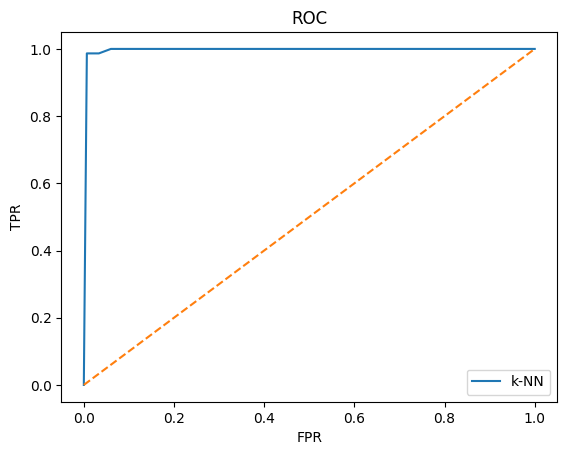

/tmp/ipython-input-529158130.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = float(np.trapz(prec, rec))


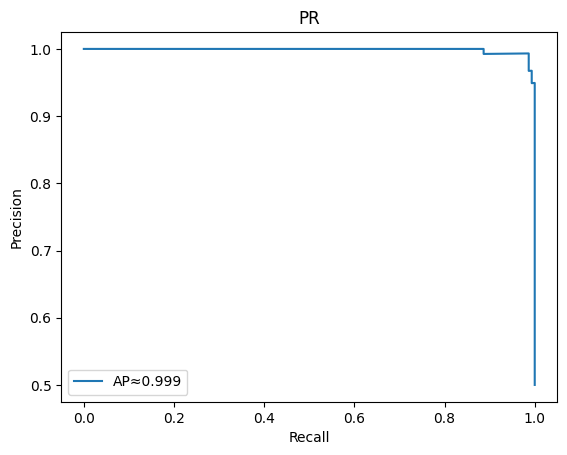

In [6]:

def make_binary_blobs(n=1200, d=2, sep=4.5, random_state=3):
    rng = np.random.RandomState(random_state)
    n1 = n//2; n0 = n - n1
    mu1 = np.zeros(d); mu1[0]=+sep/2.0
    mu0 = np.zeros(d); mu0[0]=-sep/2.0
    X1 = rng.normal(mu1, 1.0, size=(n1,d))
    X0 = rng.normal(mu0, 1.0, size=(n0,d))
    X = np.vstack([X0,X1]); y = np.array([0]*n0 + [1]*n1)
    return X, y

X, y = make_binary_blobs()

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

grid = cross_val_score_knn(Xtr, ytr, k_values=list(range(1,31)), p_values=(1,2), weights=('uniform','distance'),
                           metric='minkowski', n_splits=5, scorer='f1_macro', scale=True, random_state=7)
best = grid[0]; print("Best hyperparams (CV):", best)

scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr); Xte_s = scaler.transform(Xte)
clf = KNNClassifier(n_neighbors=best["k"], p=best["p"], weights=best["weights"]).fit(Xtr_s, ytr)
yhat = clf.predict(Xte_s)

def roc_curve_binary(y_true, scores):
    y_true = np.asarray(y_true).astype(int); scores = np.asarray(scores).astype(float)
    order = np.argsort(-scores); y_true = y_true[order]; scores = scores[order]
    P = np.sum(y_true==1); N = np.sum(y_true==0)
    tpr=[0.0]; fpr=[0.0]; tp=0; fp=0; last=None
    for s,yt in zip(scores, y_true):
        if last is None or s!=last:
            tpr.append(tp/P if P>0 else 0.0); fpr.append(fp/N if N>0 else 0.0); last=s
        if yt==1: tp+=1
        else: fp+=1
    tpr.append(tp/P if P>0 else 0.0); fpr.append(fp/N if N>0 else 0.0)
    return np.array(fpr), np.array(tpr)

def precision_recall_curve_binary(y_true, scores):
    y_true = np.asarray(y_true).astype(int); scores = np.asarray(scores).astype(float)
    order = np.argsort(-scores); y_true = y_true[order]
    tp=0; fp=0; P = np.sum(y_true==1); prec=[1.0]; rec=[0.0]
    for yt in y_true:
        if yt==1: tp+=1
        else: fp+=1
        prec.append(tp/(tp+fp) if (tp+fp)>0 else 1.0)
        rec.append(tp/P if P>0 else 0.0)
    return np.array(rec), np.array(prec)

proba = clf.predict_proba(Xte_s)[:,1]
fpr, tpr = roc_curve_binary(yte, proba)
plt.figure(); plt.plot(fpr, tpr, label="k-NN"); plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

rec, prec = precision_recall_curve_binary(yte, proba)
ap = float(np.trapz(prec, rec))
plt.figure(); plt.plot(rec, prec, label=f"AP≈{ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR"); plt.legend(); plt.show()


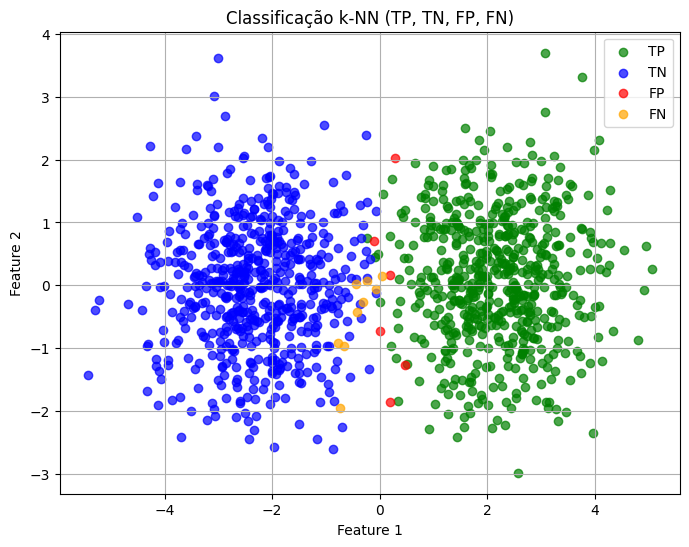

591
594
6
9


In [7]:

y_true = y

X_scaled = scaler.transform(X.astype(float))
y_pred = clf.predict(X_scaled)

# Identificar TP, TN, FP, FN
# supondo 1 positivo e 0 negativo
tp_mask = (y_true == 1) & (y_pred == 1)
tn_mask = (y_true == 0) & (y_pred == 0)
fp_mask = (y_true == 0) & (y_pred == 1)
fn_mask = (y_true == 1) & (y_pred == 0)

plt.figure(figsize=(8, 6))

# Plot cada tipo (tp,tn,fp,fn) com uma cor diferente
plt.scatter(X[tp_mask, 0], X[tp_mask, 1], color='green', label='TP', alpha=0.7)
plt.scatter(X[tn_mask, 0], X[tn_mask, 1], color='blue', label='TN', alpha=0.7)
plt.scatter(X[fp_mask, 0], X[fp_mask, 1], color='red', label='FP', alpha=0.7)
plt.scatter(X[fn_mask, 0], X[fn_mask, 1], color='orange', label='FN', alpha=0.7)


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Classificação k-NN (TP, TN, FP, FN)")
plt.legend()
plt.grid(True)
plt.show()
print(np.sum(tp_mask))
print(np.sum(tn_mask))
print(np.sum(fp_mask))
print(np.sum(fn_mask))

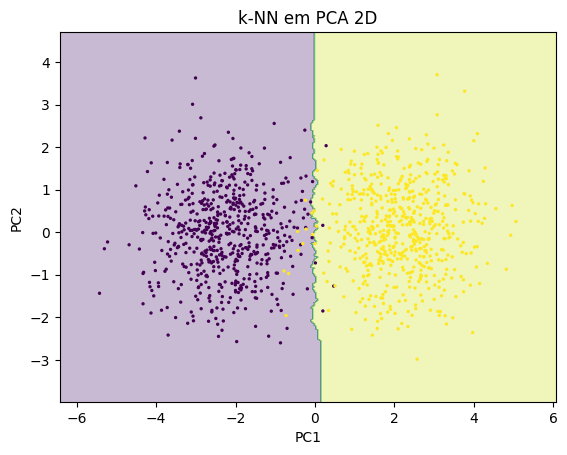

In [8]:
x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(grid).reshape(xx.shape)

plt.figure(); plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=y+1, s=2)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("k-NN em PCA 2D"); plt.show()

## Demo 2 — Multiclasse + PCA via SVD

Melhor (multiclasse): {'k': 27, 'p': 2, 'weights': 'uniform', 'metric': 'minkowski', 'score': 0.5670438843672997}


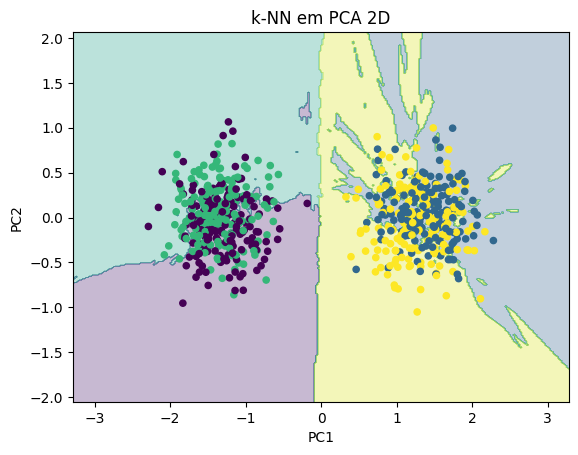

In [9]:

def make_multiclass_blobs(n=900, d=2, centers=4, sep=5.5, random_state=1):
    rng = np.random.RandomState(random_state)
    n_per = n//centers; mus = []
    for i in range(centers):
        mu = rng.normal(0, 0.2, size=d); mu[i % d] += sep; mus.append(mu)
    Xs, ys = [], []
    for i, mu in enumerate(mus):
        Xs.append(rng.normal(mu, 1.0, size=(n_per, d))); ys.extend([i]*n_per)
    return np.vstack(Xs), np.array(ys)

class PCA:
    def __init__(self, n_components=2):
        self.n_components=n_components; self.mean_=None; self.components_=None
    def fit(self, X):
        X=np.asarray(X,float); self.mean_=X.mean(axis=0,keepdims=True)
        Xc = X - self.mean_; U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
        self.components_ = Vt[:self.n_components]; return self
    def transform(self, X): return (np.asarray(X,float)-self.mean_) @ self.components_.T
    def fit_transform(self, X): return self.fit(X).transform(X)

X3, y3 = make_multiclass_blobs()

X3tr, X3te, y3tr, y3te = train_test_split(X3, y3, test_size=0.25, random_state=37, stratify=y3)

res = cross_val_score_knn(X3tr, y3tr, k_values=list(range(1,31)), p_values=(1,2), weights=('uniform','distance'),
                          metric='minkowski', n_splits=5, scorer='f1_macro', scale=True, random_state=9)
best3 = res[0]; print("Melhor (multiclasse):", best3)

scaler3 = StandardScaler().fit(X3tr)
X3tr_s = scaler3.transform(X3tr); X3te_s = scaler3.transform(X3te)
clf3 = KNNClassifier(n_neighbors=best3["k"], p=best3["p"], weights=best3["weights"]).fit(X3tr_s, y3tr)

# PCA só para visualizar
pca = PCA(n_components=2).fit(X3tr_s)
Ztr = pca.transform(X3tr_s); Zte = pca.transform(X3te_s)
clf2d = KNNClassifier(n_neighbors=best3["k"], p=best3["p"], weights=best3["weights"]).fit(Ztr, y3tr)

# Região de decisão
x_min, x_max = Ztr[:,0].min()-1.0, Ztr[:,0].max()+1.0
y_min, y_max = Ztr[:,1].min()-1.0, Ztr[:,1].max()+1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf2d.predict(grid).reshape(xx.shape)

plt.figure(); plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(Ztr[:,0], Ztr[:,1], c=y3tr, s=20)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("k-NN em PCA 2D"); plt.show()


In [10]:

y_pred_wine_multiclass = clf3.predict(X3te_s)


conf_matrix, labels = confusion_matrix(y3te, y_pred_wine_multiclass)
print("Confusion Matrix:")
display(pd.DataFrame(conf_matrix, index=labels, columns=labels))


accuracy_wine_multiclass = accuracy(y3te, y_pred_wine_multiclass)
print(f"\nAccuracy: {accuracy_wine_multiclass:.4f}")


macro_f1_wine_multiclass = macro_f1(y3te, y_pred_wine_multiclass)
print(f"Macro F1 Score: {macro_f1_wine_multiclass:.4f}")

Confusion Matrix:


,0,1,2,3
0,29,0,27,0
1,0,41,0,15
2,23,0,33,0
3,0,27,0,29



Accuracy: 0.5893
Macro F1 Score: 0.5868


# Tarefa


Use as funções criadas para modelar os dados dos pinguins.

In [67]:
import pandas as pd
import seaborn as sns

df_penguins = sns.load_dataset('penguins')
df_penguins['species'].value_counts()
df_penguins.dropna(inplace=True)

In [17]:
df_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [71]:
colunas_para_dropar = ['species', 'island', 'sex','body_mass_g','flipper_length_mm']
Xp = df_penguins.drop(colunas_para_dropar, axis=1)
Xp=Xp.values
species_map = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
yp = df_penguins['species'].map(species_map).values               # Variável resposta

Xptr, Xpte, yptr, ypte = train_test_split(Xp, yp, test_size=0.25, random_state=42, stratify=yp)

grid = cross_val_score_knn(Xptr, yptr, k_values=list(range(1,31)), p_values=(1,2), weights=('uniform','distance'),
                           metric='minkowski', n_splits=5, scorer='f1_macro', scale=True, random_state=7)
best = grid[0]; print("Best hyperparams (CV):", best)

Best hyperparams (CV): {'k': 5, 'p': 1, 'weights': 'uniform', 'metric': 'minkowski', 'score': 0.9752829390357995}


In [75]:
best_knn = KNNClassifier(
    n_neighbors=best['k'],
    p=best['p'],
    weights=best['weights'],
    metric=best['metric']
)

AVALIAÇÃO FINAL DO MODELO KNN (com normalização)
Melhores parâmetros: {'k': 5, 'p': 1, 'weights': 'uniform', 'metric': 'minkowski', 'score': 0.9752829390357995}
Macro F1: 0.9243
Acurácia: 0.9390


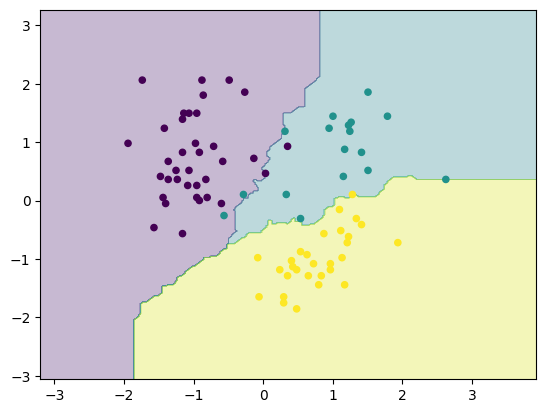


Matriz de Confusão:
True 0: [ 35   1   0]
True 1: [  2  14   1]
True 2: [  0   1  28]
Pred:    0   1   2  


In [80]:
# 1. Normalizar- scaler = StandardScaler().fit(Xtr) - Xtr = scaler.transform(Xtr); Xva = scaler.transform(Xva)
scaler2 = StandardScaler().fit(Xptr)
Xptr_s = scaler2.transform(Xptr)
Xpte_s = scaler2.transform(Xpte)

#Xptr_s = Xptr
#Xpte_s = Xpte
# 2. Treinar
best_knn.fit(Xptr_s, yptr)

# 3. Prever
y_pred = best_knn.predict(Xpte_s)

# 4. Avaliar
print("=" * 60)
print("AVALIAÇÃO FINAL DO MODELO KNN (com normalização)")
print("=" * 60)
print(f"Melhores parâmetros: {best}")
print(f"Macro F1: {macro_f1(ypte, y_pred):.4f}")
print(f"Acurácia: {accuracy(ypte, y_pred):.4f}")

x_min, x_max = Xptr_s[:,0].min()-1.0, Xptr_s[:,0].max()+1.0
y_min, y_max = Xptr_s[:,1].min()-1.0, Xptr_s[:,1].max()+1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = best_knn.predict(grid).reshape(xx.shape)

plt.figure(); plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(Xpte_s[:,0], Xpte_s[:,1], c=ypte, s=20)

plt.show()

M, labels = confusion_matrix(ypte, y_pred)
print("\nMatriz de Confusão:")
for i, true_label in enumerate(labels):
    row = " ".join(f"{M[i,j]:3d}" for j in range(len(labels)))
    print(f"True {true_label}: [{row}]")
print("Pred:    " + " ".join(f"{l:3s}" for l in map(str, labels)))

In [12]:
# Resultado pode ficar parecido com isso.


# Tarefa 2

Utilize esse tipo de modelos para prever os dados do conjunto de vinhos.

- Depois de tentar classificar todas as qualidades simultaneamente, experimente não classificar todas as qualidades, mas apenas vinhos acima de um certa qualidade. Mostre as métricas quando considera todas as classes e como o modelo melhora quando considera um conjunto de classes, por exemplo, baixa média e alta qualidade, ou baixa e alta.

In [78]:
wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
wine_df = pd.read_csv(wine_url, sep=';')

wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [79]:
wine_df.dropna()



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [93]:
wine_df['quality'].value_counts()
Xw = wine_df.drop('quality', axis=1)
Xw = Xw.values
yw = wine_df['quality']

Xwtr, Xwte, ywtr, ywte = train_test_split(Xw, yw, test_size=0.25, random_state=42, stratify=yw)

grid= cross_val_score_knn(Xwtr, ywtr, k_values=list(range(1,31)), p_values=(1,2), weights=('uniform','distance'),
                           metric='minkowski', n_splits=5, scorer='f1_macro', scale=True, random_state=7)
best = grid[0]; print("Best hyperparams (CV):", best)


Best hyperparams (CV): {'k': 9, 'p': 1, 'weights': 'distance', 'metric': 'minkowski', 'score': 0.34321887916504507}


In [95]:
best_knn_w = KNNClassifier(
    n_neighbors=best['k'],
    p=best['p'],
    weights=best['weights'],
    metric=best['metric']
)

In [97]:
# 1. Normalizar- scaler = StandardScaler().fit(Xtr) - Xtr = scaler.transform(Xtr); Xva = scaler.transform(Xva)
scaler = StandardScaler().fit(Xwtr)
Xwtr_s = scaler.transform(Xwtr)
Xwte_s = scaler.transform(Xwte)

best_knn.fit(Xwtr_s, ywtr)

# 3. Prever
y_pred = best_knn.predict(Xwte_s)

# 4. Avaliar
print("=" * 60)
print("AVALIAÇÃO FINAL DO MODELO KNN (com normalização)")
print("=" * 60)
print(f"Melhores parâmetros: {best}")
print(f"Macro F1: {macro_f1(ywte, y_pred):.4f}")
print(f"Acurácia: {accuracy(ywte, y_pred):.4f}")

M, labels = confusion_matrix(ywte, y_pred)
print("\nMatriz de Confusão:")
for i, true_label in enumerate(labels):
    row = " ".join(f"{M[i,j]:3d}" for j in range(len(labels)))
    print(f"True {true_label}: [{row}]")
print("Pred:    " + " ".join(f"{l:3s}" for l in map(str, labels)))

AVALIAÇÃO FINAL DO MODELO KNN (com normalização)
Melhores parâmetros: {'k': 9, 'p': 1, 'weights': 'distance', 'metric': 'minkowski', 'score': 0.34321887916504507}
Macro F1: 0.3221
Acurácia: 0.6751

Matriz de Confusão:
True 3: [  0   0   1   1   0   0]
True 4: [  0   0   9   4   0   0]
True 5: [  0   0 137  31   2   0]
True 6: [  0   1  35 108  15   0]
True 7: [  0   0   3  23  23   0]
True 8: [  0   0   0   1   3   0]
Pred:    3   4   5   6   7   8  


In [98]:
wine_df['quality'].value_counts()

,count
quality,
5,681
6,638
7,199
4,53
8,18
3,10


In [102]:
y_gp = np.where(yw <= 5, 0,
             np.where(yw == 6, 1, 2))

Xwtr, Xwte, ywtr, ywte = train_test_split(Xw, y_gp, test_size=0.25, random_state=42, stratify=y_gp)

grid= cross_val_score_knn(Xwtr, ywtr, k_values=list(range(1,31)), p_values=(1,2), weights=('uniform','distance'),
                           metric='minkowski', n_splits=5, scorer='f1_macro', scale=True, random_state=7)
best = grid[0]; print("Best hyperparams (CV):", best)

Best hyperparams (CV): {'k': 14, 'p': 2, 'weights': 'distance', 'metric': 'minkowski', 'score': 0.656791917014699}


In [103]:
best_knn_w_gp = KNNClassifier(
    n_neighbors=best['k'],
    p=best['p'],
    weights=best['weights'],
    metric=best['metric']
)

In [104]:
scaler = StandardScaler().fit(Xwtr)
Xwtr_s = scaler.transform(Xwtr)
Xwte_s = scaler.transform(Xwte)

best_knn.fit(Xwtr_s, ywtr)

# 3. Prever
y_pred = best_knn.predict(Xwte_s)

# 4. Avaliar
print("=" * 60)
print("AVALIAÇÃO FINAL DO MODELO KNN (com normalização)")
print("=" * 60)
print(f"Melhores parâmetros: {best}")
print(f"Macro F1: {macro_f1(ywte, y_pred):.4f}")
print(f"Acurácia: {accuracy(ywte, y_pred):.4f}")

M, labels = confusion_matrix(ywte, y_pred)
print("\nMatriz de Confusão:")
for i, true_label in enumerate(labels):
    row = " ".join(f"{M[i,j]:3d}" for j in range(len(labels)))
    print(f"True {true_label}: [{row}]")
print("Pred:    " + " ".join(f"{l:3s}" for l in map(str, labels)))

AVALIAÇÃO FINAL DO MODELO KNN (com normalização)
Melhores parâmetros: {'k': 14, 'p': 2, 'weights': 'distance', 'metric': 'minkowski', 'score': 0.656791917014699}
Macro F1: 0.6348
Acurácia: 0.6767

Matriz de Confusão:
True 0: [147  36   3]
True 1: [ 43  96  20]
True 2: [  4  23  27]
Pred:    0   1   2  
